## Code using NLP to predict which tweets are about natural disasters.

### - Import modules -

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import re
import string

#### Read in the data

In [2]:
all_train_data = pd.read_csv('train.csv')
shuffled_all_train_data = all_train_data.sample(frac = 1)

### - Analyse and tidy the data -

In [3]:
print(all_train_data.head())
print(all_train_data['target'].value_counts(normalize = True))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
0    0.57034
1    0.42966
Name: target, dtype: float64


#### Split the data into sentences and labels
Note there is also a keyword and location field that can be used but might be blank. For now, I stick with the completed data - so the tweet is the only feature used.

In [4]:
sentences = shuffled_all_train_data['text'].tolist()
labels = shuffled_all_train_data['target'].tolist()

#### Look at some examples of tweets and their labels

In [5]:
print("data length = ", len(sentences))
print(sentences[:10])
print(labels[:10])

data length =  7613
['@kessily @mishacollins So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES', 'Stay cautious. http://t.co/JeJC9XcTMp', 'Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies', '@fouseyTUBE you ok? Need a ambulance. Hahahah that was good! http://t.co/ZSbErqNN9n', 'Dont even come if you worried about curfew #BC19', 'Truck Driver Salvages Banned Tomatoes From Destruction on #Russian Border http://t.co/7b2Wf6ovFK #news', 'Want to work in #MissionHills CA? View our latest opening: http://t.co/ZsnSaR1Tw1 #Nursing #Job #Jobs #Hiring', 'Storm batters top half of North Island: A violent overnight storm has battered the upper North Island uprootin... http://t.co/fHVOkmpheD', 'Madhya Pradesh Train Derailment: Village Youth Saved Many Lives', 'A Cessna airplane accident in Ocampo Coahuila Mexico on July 29 2015 killed four men including a State of Coahuila government official.']
[0, 0, 0, 0, 0, 0, 0,

#### Look at length of tweets in terms of number of characters

In [6]:
max = 0
for sentence in sentences:
    length = len(sentence)
    if length > max:
        max = length
        print(max)
        print(sentence)

print("Max length = ", max)

139
@kessily @mishacollins So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES
140
#aerospace #exec Plane debris is from missing MH370 - Part of the aircraft wing found on Reunion Island is from th... http://t.co/S2wm8lh7oO
142
This just-married Turkish couple gave 4000 Syrian refugees an incredible gift http://t.co/ibeD3xG7fy Fed them instead of family &amp; friends.
148
Just stop fucking saying ÛÏa whole Û÷notherÛ. It just sounds fucking stupid. You fucking mean ÛÏa whole otherÛ. Not a fucking tongue-twister.
150
@HowardU If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?
151
@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP
152
It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally 

### - Tokenize the words -
We now tokenize the 100 most common words by assigning them a number and then turning the tweets into sequences to train the model. In the model, we have an embedding dimension which assigns a vector for each word and allows words with similar meanings to appear close in the embedding parameter space, e.g., words that are negative in sentiment would have similar vectors.

We can see from example data that many tweets have URLs, user names, hashtags and numbers.
We could process these to tidy the data - however, unless we create additional features to train the model, 
then there is no point pre-processing as the tokenizer will simply replace these values with an out-of-value token.

In [7]:
## Tokenize most 1000 common words
vocab_size = 1000 

## Embedding dimension size
embedding_size = 6

## Where to truncate tweets that are too long (won't be needed)
trunc_type = 'post' 

## Where to pad tweets that are too long
padding_type = 'post'

## Token used for words outside of vocab which get tokenized as 1 (check this)
oov_tok = '<OOV>' 

#### Initialise the tokenizer

In [8]:
tokeniser = Tokenizer(num_words = vocab_size, 
                      oov_token = oov_tok,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n|', ## by default, all punctuation is filtered
                      lower=True, ## Make tweets all lowercase
                      split = ' ',) 

In [9]:
## tokenise the words
tokeniser.fit_on_texts(sentences) 

## Extract the word index
word_index = tokeniser.word_index 

#### Look at the words that have been tokenised.

In [16]:
print("{:<15} {:<10}".format('Label','Number'))
index = list(word_index.items())
for i in range(10):
    label, num = index[i]
    print("{:<15} {:<10}".format(label, num))

Label           Number    
<OOV>           1         
t               2         
co              3         
http            4         
the             5         
a               6         
in              7         
to              8         
of              9         
and             10        


#### Tidy the tweets
Based on the above word_index, can see many things are being tokenized that won't play a role in classification,
e.g., numbers or https labels. Because only the 1000 most common words are retained, having common but generally not as useful
things tokenized means that we lose useful information.
Can also see with Hashtag symbols removed, but the joined words forming the hashtag aren't.

In below, rather than substitute numbers, urls etc. by a token word, we simply remove them as these features won't mix well with the tokeniser - they won't make sense in sequences.

#### Find all instances of hashtags

In [17]:
matches = shuffled_all_train_data["text"].str.extract(r"(?P<Hashtag>[#])(?P<Word>\w+)\b")
print(matches.dropna()['Word'])

2918    AllTheKidneyBeansAndSorbet4Misha
1943                                BC19
2621                             Russian
3219                        MissionHills
2163                           aerospace
                      ...               
124                                 book
181                           justsaying
6047                                 gif
1249                    PPSellsBabyParts
6623                                News
Name: Word, Length: 1743, dtype: object


#### Remove all URLs

In [18]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_URL)

with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

2918    @kessily @mishacollins So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES
4347                                                                                                                             Stay cautious. URL
5771                                                                             Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
185                                                                                @fouseyTUBE you ok? Need a ambulance. Hahahah that was good! URL
1943                                                                                               Dont even come if you worried about curfew #BC19
                                                                           ...                                                                     
4715                                                                            My hands are cold but my feet ar

#### Remove the https label

In [19]:
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_HTML)

with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

2918    @kessily @mishacollins So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES
4347                                                                                                                             Stay cautious. URL
5771                                                                             Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
185                                                                                @fouseyTUBE you ok? Need a ambulance. Hahahah that was good! URL
1943                                                                                               Dont even come if you worried about curfew #BC19
                                                                           ...                                                                     
4715                                                                            My hands are cold but my feet ar

#### Remove mentions

In [20]:
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'MENTION',text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_mention)
print(shuffled_all_train_data["text"])

2918    MENTION MENTION So we should send it all 2 him...
4347                                   Stay cautious. URL
5771    Stuart Broad Takes Eight Before Joe Root Runs ...
185     MENTION you ok? Need a ambulance. Hahahah that...
1943     Dont even come if you worried about curfew #BC19
                              ...                        
4715    My hands are cold but my feet are warm. That's...
1366    Where are the protests ? The riots? The burnin...
168     airplane crashes on house in Colombia 12 peopl...
6623    Truth...\nURL\n#News\n#BBC\n#CNN\n#Islam\n#Tru...
915     'I came to kill Indians...for FUN': Video of s...
Name: text, Length: 7613, dtype: object


#### Remove non ASCII characters

In [21]:
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_not_ASCII)
with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

2918    MENTION MENTION So we should send it all 2 him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbet4Misha #YES
4347                                                                                                                      Stay cautious. URL
5771                                                                      Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
185                                                                             MENTION you ok? Need a ambulance. Hahahah that was good! URL
1943                                                                                        Dont even come if you worried about curfew #BC19
                                                                        ...                                                                 
4715                                                                     My hands are cold but my feet are warm. That's where I keep my lava
1366         

#### Remove numbers

In [22]:
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

shuffled_all_train_data["text"] = shuffled_all_train_data["text"].apply(remove_number)
with pd.option_context('display.max_colwidth', None):
    print(shuffled_all_train_data["text"])

2918    MENTION MENTION So we should send it all NUMBER him then? Drown him in it? I like the way u think! #AllTheKidneyBeansAndSorbetNUMBERMisha #YES
4347                                                                                                                                Stay cautious. URL
5771                                                                                Stuart Broad Takes Eight Before Joe Root Runs Riot Against Aussies
185                                                                                       MENTION you ok? Need a ambulance. Hahahah that was good! URL
1943                                                                                              Dont even come if you worried about curfew #BCNUMBER
                                                                             ...                                                                      
4715                                                                               My hands ar

#### Create new tidy sentences

In [23]:
tidy_sentences = shuffled_all_train_data['text'].tolist()

### Retokenise the tidy tweets

In [24]:
new_tokeniser = Tokenizer(num_words = vocab_size, 
                      oov_token = oov_tok,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n|\'',
                      lower=True, ## Make tweets all lowercase
                      split = ' ',) 

## tokenise the words
new_tokeniser.fit_on_texts(tidy_sentences) 

## Extract the word index
new_word_index = new_tokeniser.word_index 

#### Look at the tokenised words again
Find the data is now a lot cleaner. There are still ways it could be cleaned further (for example, there are a few odd letters that appear on their own) if we need to improve the model

In [39]:
print("{:<15} {:<10}".format('Label','Number'))

for it in range(10):
    key = list(new_word_index)[it]
    value = list(new_word_index.values())[it]
    label = key
    num = value
    print("{:<15} {:<10}".format(label, num))

Label           Number    
<OOV>           1         
url             2         
the             3         
mention         4         
a               5         
number          6         
in              7         
to              8         
of              9         
i               10        


#### Split the data into a train, test and validation set 

In [26]:
cutone = int(len(tidy_sentences)*0.6)
cuttwo = int(len(tidy_sentences)*0.8)

train_sentences = tidy_sentences[:cutone]
validation_sentences = tidy_sentences[cutone:cuttwo]
test_sentences = tidy_sentences[cuttwo:]

train_labels = np.array(labels[:cutone])
validation_labels = np.array(labels[cutone:cuttwo])
test_labels = np.array(labels[cuttwo:])

print(len(train_labels))
print(len(train_sentences))
print(len(validation_labels))
print(len(validation_sentences))
print(len(test_labels))
print(len(test_sentences))

4567
4567
1523
1523
1523
1523


#### Create sequences

In [27]:
sequences = new_tokeniser.texts_to_sequences(tidy_sentences)
train_sequences = new_tokeniser.texts_to_sequences(train_sentences) 
validation_sequences = new_tokeniser.texts_to_sequences(validation_sentences) 
test_sequences = new_tokeniser.texts_to_sequences(test_sentences) 

#### Pad the tweets to limit of largest tweet

In [28]:
## Max sequence length
seq_max = 0
for sequence in sequences:
    length = len(sequence)
    if length > seq_max:
        seq_max = length
        print(seq_max)
        print(sequence)
print("Max sequence length = ", seq_max)

23
[4, 4, 37, 40, 177, 529, 17, 43, 6, 180, 152, 490, 180, 7, 17, 10, 30, 3, 150, 81, 140, 1, 641]
26
[1, 1, 34, 58, 24, 1, 39, 30, 10, 101, 3, 1, 1, 52, 10, 141, 3, 768, 419, 24, 742, 36, 955, 72, 5, 77]
27
[4, 1, 10, 1, 209, 115, 9, 3, 1, 6, 468, 575, 1, 12, 1, 22, 3, 832, 31, 19, 53, 216, 575, 128, 157, 1, 1]
32
[7, 3, 1, 9, 313, 18, 771, 282, 18, 414, 6, 57, 17, 13, 92, 8, 6, 11, 10, 51, 196, 121, 42, 11, 145, 1, 99, 10, 38, 283, 21, 149]
33
[1, 14, 182, 68, 142, 69, 34, 191, 48, 263, 50, 1, 1, 1, 34, 23, 154, 5, 273, 23, 3, 1, 1, 16, 3, 1, 401, 10, 189, 472, 149, 22, 1]
Max sequence length =  33


In [29]:
## max length of each tweet
max_length = seq_max


train_padded = pad_sequences(train_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)
validation_padded = pad_sequences(validation_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)
test_padded = pad_sequences(test_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)

print(len(train_sequences))
print(len(train_padded))
print(len(validation_sequences))
print(len(validation_padded))
print(len(test_sequences))
print(len(test_padded))

4567
4567
1523
1523
1523
1523


### - Compile and train the neural network -

In [40]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_size, input_length = max_length), 
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation = 'relu'),
                             tf.keras.layers.Dense(1, activation = 'sigmoid'),
                             ])

In [41]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics = ['accuracy']) 

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 6)             6000      
                                                                 
 global_average_pooling1d_1   (None, 6)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [43]:
num_epochs = 300
history = model.fit(train_padded,
          train_labels,
          epochs = num_epochs,
          callbacks=[callback],
          validation_data = (validation_padded, validation_labels),
          verbose = 0)     

#### Cross validation plots
Find the validation loss starts to plateau at around 140 epochs, but doesn't start to increase. There is some overfitting as the train loss keeps decreasing.

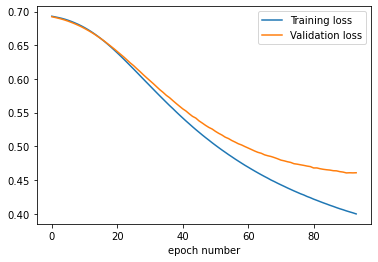

In [44]:
val_loss = history.history['val_loss']
epoch_range = range(len(val_loss))
plt.plot(epoch_range, history.history['loss'], label = 'Training loss')
plt.plot(epoch_range, history.history['val_loss'], label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch number')
plt.show()

#### Evaluate on the test data
Achieve an accuracy of about 81% which isn't bad for a first attempt.

In [45]:
model.evaluate(test_padded,
               test_labels,)

48/48 [==============================] - 0s 507us/step - loss: 0.4412 - accuracy: 0.8122


[0.44115859270095825, 0.8122127652168274]

### - Make predictions and submission file -
This is where the submission file is made for the Kaggle competition.

#### Load in and tokenize the test data

In [46]:
submission_test_data = pd.read_csv('test.csv') 
submission_test_sentences = submission_test_data['text'].tolist()

submission_test_sequences = tokeniser.texts_to_sequences(submission_test_sentences) # create tokenised sequences.
submission_test_padded = pad_sequences(submission_test_sequences, 
                       maxlen = max_length, 
                       padding = padding_type, 
                       truncating = trunc_type,)

#### Obtain predictions

In [47]:
new_id = submission_test_data['id']
new_predict = np.round(model.predict(submission_test_padded));

#### Save to file

In [48]:
np.savetxt('submission.csv', np.c_[new_id, new_predict], delimiter = ',', header = 'id,target', comments = '', fmt = '%d')